In [1]:
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

import cmocean.cm as cm

%matplotlib inline

In [2]:
imin, imax = 160, 350
jmin, jmax = 120, 300

In [3]:
# define region
def section(x0,y0,length,xi,yi):
    '''xi = 1 then x0-i
          = 0 then x0=i
    same for yi'''
    ii=[]
    jj=[]
    for i in range (length):
#        a.append(n_lon[x0+xi*i,y0+yi*i])
#        b.append(n_lat[x0+xi*i,y0+yi*i])
        ii.append(x0+xi*i)
        jj.append(y0+yi*i)
    return np.array(ii),np.array(jj)

/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


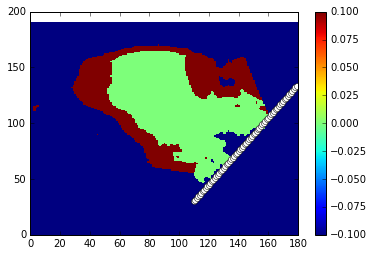

In [4]:
shallow = np.load('shallow.npy')
plt.pcolormesh(shallow[imin:imax, jmin:jmax])
plt.colorbar();
ii,jj=section(x0=190,y0=230,length=70,xi=1.5,yi=1.)
plt.plot(jj-jmin, ii-imin, 'wo')

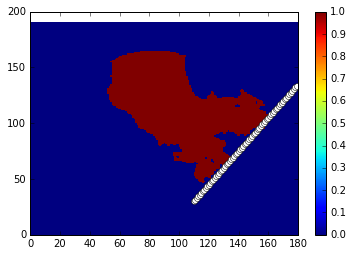

In [5]:
deep = np.load('deep.npy')
plt.pcolormesh(deep[imin:imax, jmin:jmax])
plt.colorbar()
plt.plot(jj-jmin, ii-imin, 'wo');

In [6]:
#why don't these line up'

In [170]:
bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
nemolon=bathy.variables['nav_lon'][400:,:]
nemolat=bathy.variables['nav_lat'][400:,:]
bathy=bathy.variables['Bathymetry'][400:,:]
crop = nc.Dataset(
        '/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/crop.nc')
tmask = crop.variables['tmask'][0,:,400:,:]
umask = crop.variables['umask'][0,:,400:,:]
vmask = crop.variables['vmask'][0,:,400:,:]
gdept = crop.variables['gdept'][0, :, 400:, :]
gdept0 = crop.variables['gdept_0'][0, :]
e2t = crop.variables['e2t'][0, 400:, :]
e1t = crop.variables['e1t'][0, 400:, :]
e3t = crop.variables['e3t'][0, :, 400:, :]

In [144]:
#fluxout1
ddi = 100
line1_imin, line1_imax = imin, imin+ddi
line1_jmin, line1_jmax = jmin+120, jmin+120
line2_imin, line2_imax = imin+ddi, imin+ddi
line2_jmin, line2_jmax = jmin+120, jmin+150
line3_imin, line3_imax = imin+ddi, imax
line3_jmin, line3_jmax = jmin+150, jmin+150

In [81]:
#fluxout2
line1_imin, line1_imax = imin, imin+100
line1_jmin, line1_jmax = jmin+125, jmin+125
line2_imin, line2_imax = imin+100, imin+100
line2_jmin, line2_jmax = jmin+125, jmin+155
line3_imin, line3_imax = imin+100, imax
line3_jmin, line3_jmax = jmin+155, jmin+155

In [104]:
#fluxout3
line1_imin, line1_imax = imin, imin+100
line1_jmin, line1_jmax = jmin+115, jmin+115
line2_imin, line2_imax = imin+100, imin+100
line2_jmin, line2_jmax = jmin+115, jmin+145
line3_imin, line3_imax = imin+100, imax
line3_jmin, line3_jmax = jmin+145, jmin+145

In [117]:
#fluxout4
ddi = 105
line1_imin, line1_imax = imin, imin+ddi
line1_jmin, line1_jmax = jmin+120, jmin+120
line2_imin, line2_imax = imin+ddi, imin+ddi
line2_jmin, line2_jmax = jmin+120, jmin+150
line3_imin, line3_imax = imin+ddi, imax
line3_jmin, line3_jmax = jmin+150, jmin+150

In [129]:
#fluxout5
ddi = 95
line1_imin, line1_imax = imin, imin+ddi
line1_jmin, line1_jmax = jmin+120, jmin+120
line2_imin, line2_imax = imin+ddi, imin+ddi
line2_jmin, line2_jmax = jmin+120, jmin+150
line3_imin, line3_imax = imin+ddi, imax
line3_jmin, line3_jmax = jmin+150, jmin+150

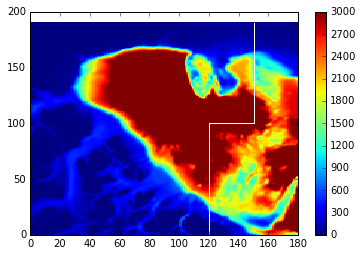

In [145]:
plt.pcolormesh(bathy[imin:imax, jmin:jmax], vmax=3000, vmin=0)
plt.colorbar()
plt.plot(np.array([line1_jmin, line1_jmax]) - jmin, np.array([line1_imin, line1_imax]) - imin, 'w')
plt.plot(np.array([line2_jmin, line2_jmax]) - jmin, np.array([line2_imin, line2_imax]) - imin, 'w')
plt.plot(np.array([line3_jmin, line3_jmax]) - jmin, np.array([line3_imin, line3_imax]) - imin, 'w')

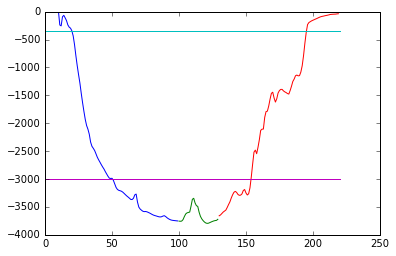

In [153]:
plt.plot(np.arange(ddi),-bathy[line1_imin:line1_imax, line1_jmin])
plt.plot(np.arange(30)+ddi, -bathy[line2_imin, line2_jmin:line2_jmax])
plt.plot(np.arange(90+100-ddi)+130-100+ddi,-bathy[line3_imin:line3_imax, line3_jmin])
plt.plot([0, 220], [-350, -350])
plt.plot([0, 220], [-3000, -3000])

In [84]:
def vel(keyword,T,ENG='EXH005'):
    """'design to obtain velocity field
    T: year, value: eg. 2002
    'ENG': string, can be ENG3,EXH001 or EXH005
    """
    if keyword =='U':
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*U*%s.nc'%(ENG,T)))
        uvel=nc.Dataset(nc_filename[0])
        data =uvel.variables['vozocrtx'][0,:,400:,:]
    elif keyword =='V':
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*V*%s.nc'%(ENG,T)))
        vvel=nc.Dataset(nc_filename[0])
        data =vvel.variables['vomecrty'][0,:,400:,:]
    else:
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*W*%s.nc'%(ENG,T)))
        wvel=nc.Dataset(nc_filename[0])
        data =wvel.variables['vovecrtz'][0,:,400:,:]
    data =np.ma.masked_where(tmask==0,data)
    return data

In [85]:
u_vel = vel('U', 2002)
v_vel = vel('V', 2002)

In [74]:
print(u_vel.shape)

(50, 400, 544)


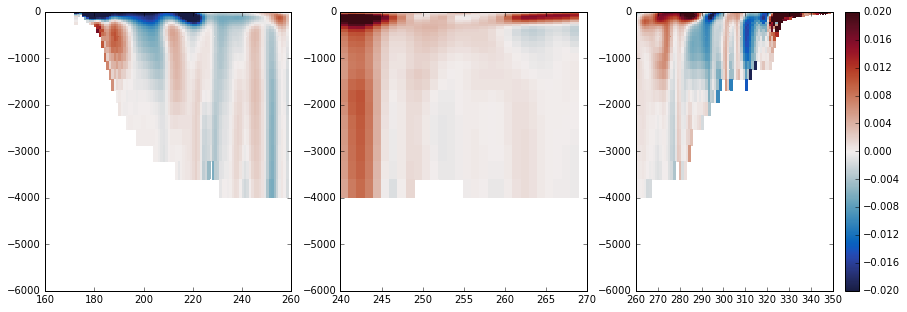

In [150]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
mesh = axs[0].pcolormesh(np.arange(line1_imin,line1_imax), -gdept0[:], 
                     u_vel[:, line1_imin:line1_imax, line1_jmin], cmap=cm.balance, vmax=0.02, vmin=-0.02)
axs[1].pcolormesh(np.arange(line2_jmin,line2_jmax), -gdept0[:], 
                     -v_vel[:, line2_imin, line2_jmin:line2_jmax], cmap=cm.balance, vmax=0.02, vmin=-0.02)
axs[2].pcolormesh(np.arange(line3_imin,line3_imax), -gdept0[:], 
                     u_vel[:, line3_imin:line3_imax, line3_jmin], cmap=cm.balance, vmax=0.02, vmin=-0.02)
#for ax in axs:
#    ax.set_ylim(-650, -350)
fig.colorbar(mesh, ax = axs[2])

In [52]:
tracerfile = nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_exh005_btscav_v2/EXH005-btscav_v2_19912016.nc')
tr8 = tracerfile.variables['TR_8'][0, :]
tr10 = tracerfile.variables['TR_10'][0, :]
tt = tr8+tr10

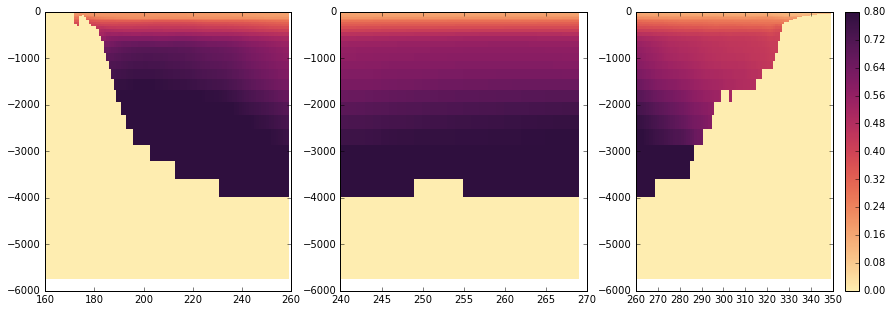

In [151]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
mesh = axs[0].pcolormesh(np.arange(line1_imin,line1_imax), -gdept0[:], 
                     tt[:, line1_imin:line1_imax, line1_jmin], cmap=cm.matter, vmax=0.8, vmin=0)
axs[1].pcolormesh(np.arange(line2_jmin,line2_jmax), -gdept0[:], 
                     tt[:, line2_imin, line2_jmin:line2_jmax], cmap=cm.matter, vmax=0.8, vmin=0)
axs[2].pcolormesh(np.arange(line3_imin,line3_imax), -gdept0[:], 
                     tt[:, line3_imin:line3_imax, line3_jmin], cmap=cm.matter, vmax=0.8, vmin=0)

#axs[0].set_ylim(-4100, -500)
fig.colorbar(mesh, ax = axs[2])

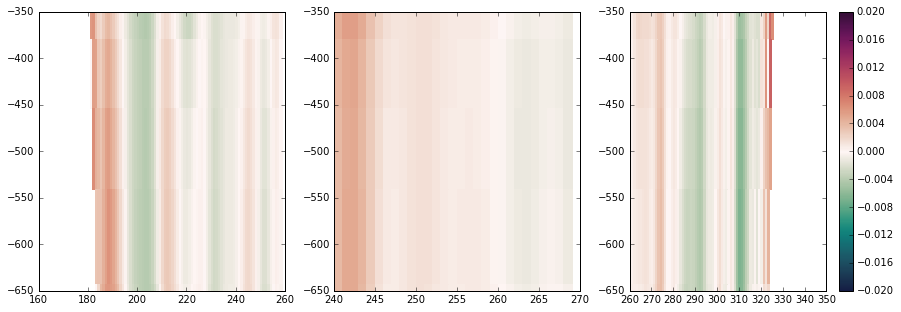

In [209]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
mesh = axs[0].pcolormesh(np.arange(line1_imin,line1_imax), -gdept0[:], 
                     u_vel[:, line1_imin:line1_imax, line1_jmin] * tt[:, line1_imin:line1_imax, line1_jmin], cmap=cm.curl, vmax=0.02, vmin=-0.02)
axs[1].pcolormesh(np.arange(line2_jmin,line2_jmax), -gdept0[:], 
                     -v_vel[:, line2_imin, line2_jmin:line2_jmax] * tt[:, line2_imin, line2_jmin:line2_jmax], cmap=cm.curl, vmax=0.02, vmin=-0.02)
axs[2].pcolormesh(np.arange(line3_imin,line3_imax), -gdept0[:], 
                     u_vel[:, line3_imin:line3_imax, line3_jmin] * tt[:, line3_imin:line3_imax, line3_jmin], cmap=cm.curl, vmax=0.02, vmin=-0.02)
for ax in axs:
    ax.set_ylim(-650, -350)
fig.colorbar(mesh, ax = axs[2])

In [191]:
fluxout = np.zeros_like(gdept0)
fluxshallow = np.zeros_like(gdept0)
fluxdeep = np.zeros_like(gdept0)
for layer in range(50):
    fluxout[layer] = (np.sum(u_vel[layer, line1_imin:line1_imax, line1_jmin] * tt[layer, line1_imin:line1_imax, line1_jmin]
         * e2t[line1_imin:line1_imax, line1_jmin] * e3t[layer, line1_imin:line1_imax, line1_jmin])
     + np.sum(-v_vel[layer, line2_imin, line2_jmin:line2_jmax] * tt[layer, line2_imin, line2_jmin:line2_jmax]
          * e1t[line2_imin, line2_jmin:line2_jmax] * e3t[layer, line2_imin, line2_jmin:line2_jmax])
     + np.sum(u_vel[layer, line3_imin:line3_imax, line3_jmin] * tt[layer, line3_imin:line3_imax, line3_jmin]
                        * e2t[line3_imin:line3_imax, line3_jmin]* e3t[layer,line3_imin:line3_imax, line3_jmin ]))
    for i in np.arange(line1_imin,line1_imax):
        if u_vel[layer, i, line1_jmin] > -15:
            if bathy[i, line1_jmin] > 3000:
                fluxdeep[layer] = fluxdeep[layer] + (u_vel[layer, i, line1_jmin] * tt[layer, i, line1_jmin]
             * e2t[i, line1_jmin] * e3t[layer, i, line1_jmin])
            else:
                fluxshallow[layer] = fluxshallow[layer] + (u_vel[layer, i, line1_jmin] * tt[layer, i, line1_jmin]
             * e2t[i, line1_jmin] * e3t[layer, i, line1_jmin])
    for j in np.arange(line2_jmin,line2_jmax):
        if v_vel[layer, line2_imin, j] > -15:
            if bathy[line2_imin, j] > 3000:
                fluxdeep[layer] = fluxdeep[layer] + (-v_vel[layer, line2_imin, j] * tt[layer, line2_imin, j]
              * e1t[line2_imin, j] * e3t[layer, line2_imin, j])
            else:
                fluxshallow[layer] = fluxshallow[layer] + (v_vel[layer, line2_imin, j] * tt[layer, line2_imin, j]
              * e1t[line2_imin, j] * e3t[layer, line2_imin, j])
    for i in np.arange(line3_imin,line3_imax):
        if u_vel[layer, i, line3_jmin] > -15:
            if bathy[i, line3_jmin] > 3000:
                fluxdeep[layer] = fluxdeep[layer] + (u_vel[layer, i, line3_jmin] * tt[layer, i, line3_jmin]
             * e2t[i, line3_jmin] * e3t[layer, i, line3_jmin])
            else:
                fluxshallow[layer] = fluxshallow[layer] + (u_vel[layer, i, line3_jmin] * tt[layer, i, line3_jmin]
             * e2t[i, line3_jmin] * e3t[layer, i, line3_jmin])               
    print(layer, gdept0[layer], fluxout[layer], fluxshallow[layer], fluxdeep[layer], fluxshallow[layer]+fluxdeep[layer]-fluxout[layer])

0 0.4940253731992925 -1078.4608711414446 -1168.497205971202 90.0363348297575 2.2737367544323206e-13
1 1.5413754434612201 -1239.9448385159887 -1305.6876786323303 65.74284011634096 -6.821210263296962e-13
2 2.6456685484563423 -1340.155143916504 -1403.8917147100897 63.73657079358643 6.821210263296962e-13
3 3.8194948417349224 -1418.3010082168717 -1491.6260997555148 73.32509153864395 6.821210263296962e-13
4 5.07822352704261 -1502.0690370484485 -1590.8331711957337 88.76413414728648 1.3642420526593924e-12
5 6.44061400319606 -1606.350578102681 -1713.9264391002882 107.57586099760877 1.5916157281026244e-12
6 7.929560286933338 -1742.1466094283323 -1857.8806200945912 115.7340106662576 -1.3642420526593924e-12
7 9.572997228664462 -1871.024284676475 -1989.6486947775545 118.62441010108067 1.1368683772161603e-12
8 11.405002865809365 -2038.3481338489041 -2139.7844934570735 101.436359608169 -4.547473508864641e-13
9 13.467138144718774 -2298.7576749416694 -2359.698683494145 60.94100855247666 9.0949470177292

/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Warning: converting a masked element to nan.


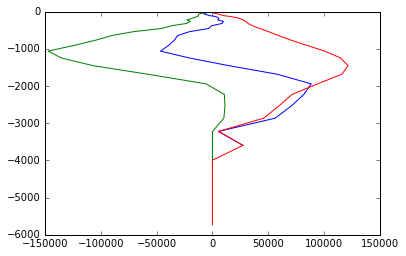

In [192]:
plt.plot(fluxout, -gdept0)
plt.plot(fluxshallow, -gdept0)
plt.plot(fluxdeep, -gdept0)

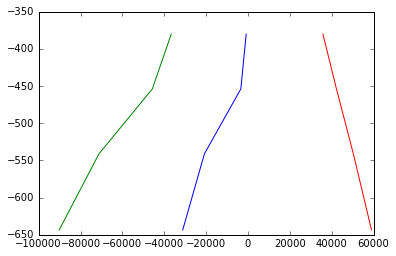

In [193]:
plt.plot(fluxout[rri:rrj], -gdept0[rri:rrj])
plt.plot(fluxshallow[rri:rrj], -gdept0[rri:rrj])
plt.plot(fluxdeep[rri:rrj], -gdept0[rri:rrj])

In [137]:
#fluxout1 = fluxout
#fluxout2 = fluxout
#fluxout3 = fluxout
#fluxout4 = fluxout
fluxout5 = fluxout

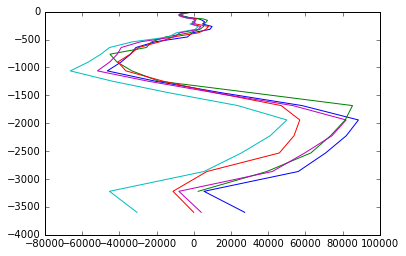

In [138]:
plt.plot(fluxout1, -gdept0)
plt.plot(fluxout2, -gdept0)
plt.plot(fluxout3, -gdept0)
plt.plot(fluxout4, -gdept0)
plt.plot(fluxout5, -gdept0)

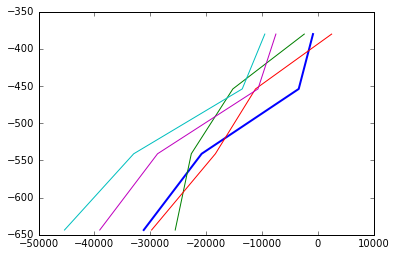

In [140]:
rri, rrj = 29, 33
plt.plot(fluxout1[rri:rrj], -gdept0[rri:rrj], linewidth=2)
plt.plot(fluxout2[rri:rrj], -gdept0[rri:rrj])
plt.plot(fluxout3[rri:rrj], -gdept0[rri:rrj])
plt.plot(fluxout4[rri:rrj], -gdept0[rri:rrj])
plt.plot(fluxout5[rri:rrj], -gdept0[rri:rrj])

In [204]:
layer_volume = np.zeros_like(gdept0)
print (line1_imin, line1_imax, jmin, line1_jmax)
print (line3_imin, line3_imax, jmin, line3_jmax)
for layer in range(50):
    layer_volume[layer] = (np.sum(e1t[line1_imin:line1_imax, jmin:line1_jmax] * 
                                 e2t[line1_imin:line1_imax, jmin:line1_jmax] * 
                                 e3t[layer, line1_imin:line1_imax, jmin:line1_jmax] * 
                                 tmask[layer, line1_imin:line1_imax, jmin:line1_jmax]) +
                           np.sum(e1t[line1_imin:line1_imax, jmin:line1_jmax] * 
                                 e2t[line1_imin:line1_imax, jmin:line1_jmax] * 
                                 e3t[layer, line1_imin:line1_imax, jmin:line1_jmax] * 
                                 tmask[layer, line1_imin:line1_imax, jmin:line1_jmax]))

160 260 120 240
260 350 120 270


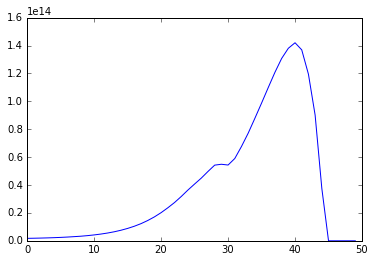

In [205]:
plt.plot(layer_volume)

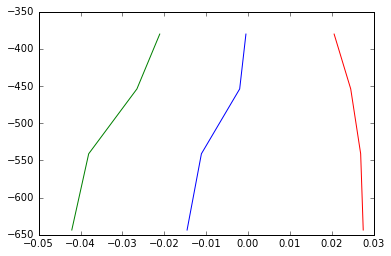

In [207]:
one_year = 365 * 86400
plt.plot(fluxout[rri:rrj]/layer_volume[rri:rrj]*one_year, -gdept0[rri:rrj])
plt.plot(fluxshallow[rri:rrj]/layer_volume[rri:rrj]*one_year, -gdept0[rri:rrj])
plt.plot(fluxdeep[rri:rrj]/layer_volume[rri:rrj]*one_year, -gdept0[rri:rrj])

## look at volume flux

In [211]:
vfluxout = np.zeros_like(gdept0)
vfluxshallow = np.zeros_like(gdept0)
vfluxdeep = np.zeros_like(gdept0)
for layer in range(50):
    vfluxout[layer] = (np.sum(u_vel[layer, line1_imin:line1_imax, line1_jmin] 
         * e2t[line1_imin:line1_imax, line1_jmin] * e3t[layer, line1_imin:line1_imax, line1_jmin])
     + np.sum(-v_vel[layer, line2_imin, line2_jmin:line2_jmax] 
          * e1t[line2_imin, line2_jmin:line2_jmax] * e3t[layer, line2_imin, line2_jmin:line2_jmax])
     + np.sum(u_vel[layer, line3_imin:line3_imax, line3_jmin] 
                        * e2t[line3_imin:line3_imax, line3_jmin]* e3t[layer,line3_imin:line3_imax, line3_jmin ]))
    for i in np.arange(line1_imin,line1_imax):
        if u_vel[layer, i, line1_jmin] > -15:
            if bathy[i, line1_jmin] > 3000:
                vfluxdeep[layer] = vfluxdeep[layer] + (u_vel[layer, i, line1_jmin]
             * e2t[i, line1_jmin] * e3t[layer, i, line1_jmin])
            else:
                vfluxshallow[layer] = vfluxshallow[layer] + (u_vel[layer, i, line1_jmin] 
             * e2t[i, line1_jmin] * e3t[layer, i, line1_jmin])
    for j in np.arange(line2_jmin,line2_jmax):
        if v_vel[layer, line2_imin, j] > -15:
            if bathy[line2_imin, j] > 3000:
                vfluxdeep[layer] = vfluxdeep[layer] + (-v_vel[layer, line2_imin, j] 
              * e1t[line2_imin, j] * e3t[layer, line2_imin, j])
            else:
                vfluxshallow[layer] = vfluxshallow[layer] + (v_vel[layer, line2_imin, j] 
              * e1t[line2_imin, j] * e3t[layer, line2_imin, j])
    for i in np.arange(line3_imin,line3_imax):
        if u_vel[layer, i, line3_jmin] > -15:
            if bathy[i, line3_jmin] > 3000:
                vfluxdeep[layer] = vfluxdeep[layer] + (u_vel[layer, i, line3_jmin] 
             * e2t[i, line3_jmin] * e3t[layer, i, line3_jmin])
            else:
                vfluxshallow[layer] = vfluxshallow[layer] + (u_vel[layer, i, line3_jmin] 
             * e2t[i, line3_jmin] * e3t[layer, i, line3_jmin])               
    print(layer, gdept0[layer], vfluxout[layer], vfluxshallow[layer], vfluxdeep[layer])

0 0.4940253731992925 -898.3226030322185 -2315.962159732487 1417.639556700268
1 1.5413754434612201 -1268.3713027193025 -2641.8736086754443 1373.5023059561368
2 2.6456685484563423 -1348.2322035483921 -2802.4901285200413 1454.257924971655
3 3.8194948417349224 -1262.5386248811756 -2873.6495904214044 1611.1109655402224
4 5.07822352704261 -1107.8627925309156 -2929.175187260115 1821.3123947291933
5 6.44061400319606 -922.6588904709824 -3002.496683606293 2079.837793135312
6 7.929560286933338 -751.8048141392428 -3060.9072840159197 2309.1024698766832
7 9.572997228664462 -200.85673941597997 -2732.9359197657827 2532.079180349819
8 11.405002865809365 431.38382566424843 -2234.3459643217775 2665.729789986016
9 13.467138144718774 720.3736645260506 -1969.8345943547436 2690.2082588808
10 15.810073307489802 487.4111533826872 -2343.5887127489123 2830.999866131587
11 18.495559580800546 -1053.6144720810335 -3937.574958323492 2883.960486242453
12 21.598815462135462 -4242.409962868878 -7510.011192637605 3267.6

/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Warning: converting a masked element to nan.


(-650, -350)

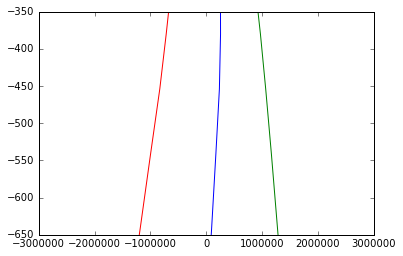

In [219]:
plt.plot(np.cumsum(vfluxout), -gdept0)
plt.plot(np.cumsum(vfluxdeep), -gdept0)
plt.plot(np.cumsum(vfluxshallow), -gdept0)
plt.ylim(-650, -350)

In [ ]:
vf = np.zeros_like(gdept0)
print (line1_imin, line1_imax, jmin, line1_jmax)
print (line3_imin, line3_imax, jmin, line3_jmax)
for layer in range(50):
    layer_volume[layer] = (np.sum(e1t[line1_imin:line1_imax, jmin:line1_jmax] * 
                                 e2t[line1_imin:line1_imax, jmin:line1_jmax] * 
                                 e3t[layer, line1_imin:line1_imax, jmin:line1_jmax] * 
                                 tmask[layer, line1_imin:line1_imax, jmin:line1_jmax]) +
                           np.sum(e1t[line1_imin:line1_imax, jmin:line1_jmax] * 
                                 e2t[line1_imin:line1_imax, jmin:line1_jmax] * 
                                 e3t[layer, line1_imin:line1_imax, jmin:line1_jmax] * 
                                 tmask[layer, line1_imin:line1_imax, jmin:line1_jmax]))